# Verify data

In this notebook I make sure I scraped the right location and time. I work out the samples needed for a representative sample. And do a visual inspection

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="" # to disable gpu, so I can do large predictions in memory
# os.environ['MKL_NUM_THREADS']="1" # limit number of cpus used

In [46]:
from path import Path
import arrow
import json
import pytz
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import re, os, collections, itertools, uuid, logging
import tempfile
# import tables
import h5py

from IPython.display import display
import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely


%matplotlib inline
# %precision 4
plt.style.use('fivethirtyeight')
# plt.rcParams['figure.figsize'] = (10, 4) # bigger plots
plt.rcParams['figure.figsize'] = (12, 6) # bigger plots
sns.set_palette("Set2", 10)

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
helper_dir = str(Path('.').abspath())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)

from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s2, download_image, bands_s2
from leak_helpers.geometry import diffxy, resample_polygon
from leak_helpers.modelling import ImageDataGenerator, dice_coef_loss
from leak_helpers.visualization import imshow_bands
from leak_helpers.analysis import parse_classification_report, find_best_dummy_classification, calculate_result_class
from leak_helpers.modelling.filters import is_not_cloudy, is_not_center_cloudy, is_image_within, is_leak, filter_split_data, is_not_dup, hash_rows, normalise_bands

Using TensorFlow backend.


In [6]:
# data_path1 = Path('../data/20170123-02-43-59_scraping_earth_engine_sentinel_2-austin_leaks_v4') # old

# compare a bunch of datasets
data_paths = [
    Path('../data/scraped_satellite_images/s2-AUTX_COPERNICUS-S2'),
    Path('../data/scraped_satellite_images/l7-AUTX_LANDSAT-LE7_L1T'),
    Path('../data/scraped_satellite_images/l8-AUTX_LANDSAT-LC8_L1T'),
    Path('../data/scraped_satellite_images/s1-AUTX_COPERNICUS-S1_GRD'),  
]

data_path1 = Path('../data/scraped_satellite_images/NAIP_AUTX-USDA-NAIP-DOQQ')  # filter to 0
data_path1 = data_paths[0]

# Path('../data/scraped_satellite_images').listdir()

# Filter

In [11]:
def get_data(data_path1):
    metadatas1 = json.load(open(data_path1.joinpath('data_metadata.json')))
    script_metadata = json.load(open(data_path1.joinpath('script_metadata.json')))
    with h5py.File(data_path1.joinpath('data.h5'),'r') as h5f:
        X1 = h5f['X'][:]
        y1 = h5f['y'][:]
#     print(X1.shape, y1.shape)
    

    filter_params=dict(
        max_cloud_cover=1.0,
        timespan_before=60*60*24*4,
        test_fraction=0.3,
#         random_seed=1337, # might be better to try differen't splits?
        balanced_classes=True,
        normalized=True,
        filter_center_cloudy=False,
    )
    X_train, y_train, metadata_train, X_val, y_val, metadata_val, X_test, y_test, metadata_test = filter_split_data(X1,y1,metadatas1, **filter_params)
#     print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
    
    X_train2 = X_train.reshape((len(X_train),-1))
    X_val2 = X_val.reshape((len(X_val),-1))
    X_test2 = X_test.reshape((len(X_test),-1))

    X_val3 = np.concatenate([X_val2,X_test2])
    y_val3 = np.concatenate([y_val,y_test])

#     print(X_train.shape,y_train.shape, len(metadata_train))
#     print(X_test.shape,y_test.shape, len(metadata_test))
#     print(X_val.shape,y_val.shape, len(metadata_val))


    return X_train2, y_train, metadata_train, X_val2, y_val, metadata_val, X_test2, y_test, metadata_test, filter_params
X_train2, y_train, metadata_train, X_val2, y_val, metadata_val, X_test2, y_test, metadata_test, filter_params = get_data(data_path1)
# X_train2.shape

# Here I want to run benchmarks over multiple datas



In [10]:
import sklearn.ensemble
import sklearn.tree
import sklearn.neural_network
import sklearn.linear_model
import time


def benchmark(X_train2, y_train, X_val2, y_val, n=5, thresh=0.5, max_depth=50):
    """Run a bunch of quick modes to benchmark dataset"""
    simple_data = []   
    sqrt_max_depth = int(np.round(np.sqrt(max_depth)))

    # http://rexdouglass.com/quick-and-dirty-land-cover-estimates-from-landsat-satellite-imagery-and-openstreetmap/
    for i in tqdm(range(n), desc='RandomForestClassifier'):
        t0=time.time()
        clf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=max_depth, 
    #         criterion='entropy',
    #         max_depth=None, 
            min_samples_split=2, 
            min_samples_leaf=2,
            max_features='auto',
            max_depth=max_depth,
            max_leaf_nodes=sqrt_max_depth,
    #         bootstrap=True,
    #         random_state=0,
            n_jobs=1, 
        )

        clf.fit(X_train2, y_train) 

        y_pred = clf.predict(X_val2)
        score = clf.score(X_val2, y_val)
        matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
        report=parse_classification_report(sklearn.metrics.classification_report(y_val > thresh, y_pred > thresh, target_names=target_names))

        simple_data.append(
            collections.OrderedDict(
                model=str(type(clf)),
                matthews_corrcoef=matthews_corrcoef,
                score=score,
                report=report,
                t=time.time()-t0
            )
        )
        
#     # http://rexdouglass.com/quick-and-dirty-land-cover-estimates-from-landsat-satellite-imagery-and-openstreetmap/
#     for i in tqdm(range(n), desc='RandomForestRegressor'):
#         t0=time.time()
#         clf = sklearn.ensemble.RandomForestRegressor(
#             n_estimators=max_depth, 
#             min_samples_split=2, 
#             min_samples_leaf=2,
#             max_features='auto',
#             max_depth=max_depth,
#             max_leaf_nodes=sqrt_max_depth,
#             n_jobs=1, 
#         )

#         clf.fit(X_train2, y_train) 

#         y_pred = clf.predict(X_val2)
#         score = clf.score(X_val2, y_val)
#         matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
#         report=parse_classification_report(sklearn.metrics.classification_report(y_val > thresh, y_pred > thresh, target_names=target_names))

#         simple_data.append(
#             collections.OrderedDict(
#                 model=str(type(clf)),
#                 matthews_corrcoef=matthews_corrcoef,
#                 score=score,
#                 report=report,
#                 t=time.time()-t0
#             )
#         )

        


    for i in tqdm(range(n), desc='DecisionTreeClassifier'):
        t0=time.time()
        clf = sklearn.tree.DecisionTreeClassifier(
            max_depth=max_depth,
            max_features='auto',
            max_leaf_nodes=sqrt_max_depth,
        )
        clf.fit(X_train2, y_train) 

        y_pred = clf.predict(X_val2)
        score = clf.score(X_val2, y_val)
        matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
        report=parse_classification_report(sklearn.metrics.classification_report(y_val > thresh, y_pred > thresh, target_names=target_names))

        simple_data.append(
            collections.OrderedDict(
                model=str(type(clf)),
                matthews_corrcoef=matthews_corrcoef,
                score=score,
                report=report,
                t=time.time()-t0
            )
        )
        
    for i in tqdm(range(n), desc='DecisionTreeClassifier'):
        t0=time.time()
        clf = sklearn.tree.DecisionTreeClassifier(
            criterion='entropy',
            max_depth=max_depth,
            max_features='auto',
            max_leaf_nodes=sqrt_max_depth,
        )
        clf.fit(X_train2, y_train) 

        y_pred = clf.predict(X_val2)
        score = clf.score(X_val2, y_val)
        matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
        report=parse_classification_report(sklearn.metrics.classification_report(y_val > thresh, y_pred > thresh, target_names=target_names))

        simple_data.append(
            collections.OrderedDict(
                model=str(type(clf))+'_entropy',
                matthews_corrcoef=matthews_corrcoef,
                score=score,
                report=report,
                t=time.time()-t0
            )
        )

    for i in tqdm(range(n), desc='DecisionTreeRegressor'):
        t0=time.time()
        clf = sklearn.tree.DecisionTreeRegressor(
            max_depth=max_depth,
            max_features='sqrt',
            max_leaf_nodes=sqrt_max_depth,
        )
        clf.fit(X_train2, y_train) 

        y_pred = clf.predict(X_val2)
        score = clf.score(X_val2, y_val)
        matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
        report=parse_classification_report(sklearn.metrics.classification_report(y_val > thresh, y_pred > thresh, target_names=target_names))

        simple_data.append(
            collections.OrderedDict(
                model=str(type(clf)),
                matthews_corrcoef=matthews_corrcoef,
                score=score,
                report=report,
                t=time.time()-t0
            )
        )

#     for i in tqdm(range(n), desc='MLPRegressor'):
#         t0=time.time()
#         clf = sklearn.neural_network.MLPRegressor(
#             hidden_layer_sizes=sqrt_max_depth,
#             max_iter=max_depth,
#             early_stopping=True,
#             learning_rate=np.random.choice(['constant', 'invscaling', 'adaptive']),            
#             batch_size=128,
# #             early_stopping=True,
#)
#         clf.fit(X_train2, y_train) 

#         y_pred = clf.predict(X_val2)
#         score = clf.score(X_val2, y_val)
#         matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
#         report=parse_classification_report(sklearn.metrics.classification_report(y_val > thresh, y_pred > thresh, target_names=target_names))


#         simple_data.append(
#             collections.OrderedDict(
#                 model=str(type(clf)),
#                 matthews_corrcoef=matthews_corrcoef,
#                 score=score,
#                 report=report,
#                 t=time.time()-t0
#             )
#         )

    for i in tqdm(range(n), desc='MLPClassifier'):  
        t0=time.time()
        clf = sklearn.neural_network.MLPClassifier(
            hidden_layer_sizes=sqrt_max_depth,
            max_iter=max_depth,
            early_stopping=True,
            learning_rate=np.random.choice(['constant', 'invscaling', 'adaptive']),            
            batch_size=128,
#             early_stopping=True,
        )
        clf.fit(X_train2, y_train) 

        y_pred = clf.predict(X_val2)
        score = clf.score(X_val2, y_val)
        matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
        report=parse_classification_report(sklearn.metrics.classification_report(y_val > thresh, y_pred > thresh, target_names=target_names))

        simple_data.append(
            collections.OrderedDict(
                model=str(type(clf)),
                matthews_corrcoef=matthews_corrcoef,
                score=score,
                report=report,
                t=time.time()-t0
            )
        )

    for i in tqdm(range(n), desc='Perceptron'):    
        t0=time.time()
        clf = sklearn.linear_model.Perceptron(
            penalty=np.random.choice([None, 'l2', 'l1', 'elasticnet']),
            n_jobs=1
        )
        clf.fit(X_train2, y_train) 

        y_pred = clf.predict(X_val2)
        score = clf.score(X_val2, y_val)
        matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
        report=parse_classification_report(sklearn.metrics.classification_report(y_val > thresh, y_pred > thresh, target_names=target_names))


        simple_data.append(
            collections.OrderedDict(
                model=str(type(clf)),
                matthews_corrcoef=matthews_corrcoef,
                score=score,
                report=report,
                t=time.time()-t0
            )
        )
    return simple_data

In [11]:
import sklearn
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
import collections
def find_best_dummy_classification(X_train, X_test, y_train, y_test, test_size=0.3, random_state=0, thresh=0.5, target_names=None, n=50):
    """Try all dummy models."""

    dummy_scores = []
    for i in range(n):
        for strategy in ['most_frequent', 'uniform', 'prior', 'stratified']:
            clf = DummyClassifier(strategy=strategy)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            score = clf.score(X_test, y_test)

            matthews_corrcoef=sklearn.metrics.matthews_corrcoef(y_test > thresh, y_pred > thresh)

            report=parse_classification_report(sklearn.metrics.classification_report(y_test > thresh, y_pred > thresh, target_names=target_names))

            dummy_scores.append(
                collections.OrderedDict(
                    strategy='classifier_' + strategy,
                    matthews_corrcoef=matthews_corrcoef,
                    score=score,
                    report=report
                )
            )

        for strategy in ['mean', 'median']:
            clf=DummyRegressor(strategy=strategy)
            clf.fit(X_train, y_train)
            y_pred=clf.predict(X_test)
            score=clf.score(X_test, y_test)

            matthews_corrcoef=sklearn.metrics.matthews_corrcoef(y_test > thresh, y_pred > thresh)

            report=parse_classification_report(sklearn.metrics.classification_report(y_test > thresh, y_pred > thresh, target_names=target_names))

            dummy_scores.append(
                collections.OrderedDict(
                    strategy='regressor_' + strategy,
                    matthews_corrcoef=matthews_corrcoef,
                    score=score,
                    report=report
                )
                )

    df=pd.DataFrame(dummy_scores)
    df=df.sort_values('matthews_corrcoef', ascending=False)
    return df, df[:1].iloc[0].to_dict()

In [29]:
# run this overnight
test_fraction=0.3
thresh=0.5
n=30
target_names=['no leak','leak']
random_seed=1337
max_depth=50

data_results=[]
for data_path1 in tqdm(data_paths, desc='data_paths'):
    X_train2, y_train, metadata_train, X_val2, y_val, metadata_val, X_test2, y_test, metadata_test, filter_params = get_data(data_path1)
    simple_data = benchmark(X_train2, y_train, X_val2, y_val, n=n, thresh=thresh, max_depth=max_depth)
    df = pd.DataFrame(simple_data)
    
#     with h5py.File(data_path1.joinpath('data.h5'),'r') as h5f:
#         X1 = h5f['X'][:]
#         y1 = h5f['y'][:]
    df_dummies, best_dummy = find_best_dummy_classification(X_train=X_train2,X_test=X_test2,y_train=y_train,y_test=y_test,n=n, target_names=target_names)
    
    results = collections.OrderedDict(
        data_set=data_path1.basename(),
        best_dummy=best_dummy,
        best_score=df.sort_values('matthews_corrcoef').iloc[-1].to_dict(),
        worst_score=df.sort_values('matthews_corrcoef').iloc[0].to_dict(),
        all_scores=df.to_dict(orient='records'),
        date=arrow.get().isoformat(),
        data_path1=data_path1,
        filter_params=filter_params,
    )
    data_results.append(results)
    
len(data_results)

/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:357: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


13

In [18]:
# save
ts=arrow.get().format('YYYY-MM-DD_HH-mm-ss')
result_path = Path('../output/2_qc_scraped_data/{ts:}_results.json'.format(ts=ts))
result_path.dirname().makedirs_p()
with open(result_path,'w') as fo:
    fo.write(pd.io.json.dumps(data_results))
result_path

Path('../output/2_qc_scraped_data/2017-03-25_04-03-59_results.json')

In [77]:
# load the saved result
# result_path = Path('../output/2_qc_scraped_data/2017-03-24_09-46-28_results.json')
result_path = Path('../output/2_qc_scraped_data/2017-03-24_10-22-47_1.5_day_filter.json')
data_results2 = pd.io.json.loads(open(result_path).read())
result_path

Path('../output/2_qc_scraped_data/2017-03-24_10-22-47_1.5_day_filter.json')

## Visualize predictive power

Lets see the predictive power of different methods. 

How to interpret this? A matthews correlation of

- ~0: **random noise** Means no predictive power, e.g. random noise
- <0: **misleading patterns** Means there was an obvious pattern in the training but it didn\'t generalise to the validation data. E.g bright images have leaks in the training set but it\'s a coincidence and doesn't hold true in the validation set
- \>0: **good** Mean there is a pattern that generalises

Differen't method will see differen't patterns but we can look at the best score and ignore the failed methods

In [78]:
# view in a dataframe
df = pd.DataFrame(data_results2)

# add some custom columns
df['mcorr_max']= df['best_score'].apply(lambda x:x['matthews_corrcoef'])
df['dummy_mcorr']= df['best_dummy'].apply(lambda x:x['matthews_corrcoef'])
df['dataset']=df.data_path1.apply(lambda x:Path(x).basename().replace('testing_earth_engine','').replace('downloaded_images_',''))
df.index=df.dataset
# df=df.sort_values('best_matthews_corrcoef')
df['mcorr_min']=df['all_scores'].apply(lambda x:pd.DataFrame(x).sort_values('matthews_corrcoef').iloc[0]['matthews_corrcoef'])
df['mcorr_mean']=df['all_scores'].apply(lambda x:pd.DataFrame(x)['matthews_corrcoef'].mean())
df['support']=df.best_dummy.apply(lambda x:x['report']['support']['avg / total']).astype(int)
# df

In [79]:
# also add f1 score related things
df['f1_leak_max']=df['all_scores'].apply(lambda x:max([b['report']['f1-score']['leak'] for b in x]))
df['f1_leak_mean']=df['all_scores'].apply(lambda x:np.mean([b['report']['f1-score']['leak'] for b in x]))
df['dummy_f1_leak']=df['best_dummy'].apply(lambda x:x['report']['f1-score']['leak'])

In [3]:
# view select columns
# df2=df[['support', 'dummy_f1_leak', 'f1_leak_max','f1_leak_mean' ]]# 'dummy_mcorr', 'mcorr_max', 'mcorr_mean', 'mcorr_min',]]
df2=df[['support', 'dummy_f1_leak', 'f1_leak_max','f1_leak_mean', 'dummy_mcorr', 'mcorr_max', 'mcorr_mean',]]
# df2=df[['support',  'dummy_mcorr', 'mcorr_max', 'mcorr_mean', 'mcorr_min','dummy_f1_leak', 'f1_leak_max','f1_leak_mean']]
df2=df2.round(3)
# print(df2.round(3).to_csv()) # https://donatstudios.com/CsvToMarkdownTable
# df2

import tabulate
markdown=tabulate.tabulate(df2,tablefmt='pipe',headers=df2.columns)
print(markdown)
df2

NameError: name 'df' is not defined

In [1]:
# make the results into a 3d panel http://pandas.pydata.org/pandas-docs/stable/dsintro.html#id2
pdp = pd.Panel(dict((x['data_path1'],pd.DataFrame(x['all_scores']).T) for x in data_results2))

sns.set_palette("hls", len(pdp.keys()))
for data_path in pdp.keys():
    mc=pdp[data_path].T
    plt.figure(figsize=(10,3))
    for model, mcc in mc.groupby('model'):
        sns.distplot(mcc['matthews_corrcoef'], hist=False, kde=True, rug=True, label=model)
    plt.title(data_path)
    plt.xlim(-0.5,0.5)
    plt.show()
    

NameError: name 'pd' is not defined

In [26]:
# # view best method for each dataset (most often random forest and DecisionTreeClass)
# for dataset in pdp.keys():
#     print(dataset)
#     by_method = pdp[dataset].T[['matthews_corrcoef','model']].groupby('model').apply(lambda x:x.matthews_corrcoef.max())
#     print(by_method)

# unit tests

In [2]:
display(list(enumerate(data_paths)))

# choose one
data_path1=data_paths[0]
print(data_path1)


NameError: name 'display' is not defined

In [116]:
metadatas1 = json.load(open(data_path1.joinpath('data_metadata.json')))
script_metadata = json.load(open(data_path1.joinpath('script_metadata.json')))
with h5py.File(data_path1.joinpath('data.h5'),'r') as h5f:
    X1 = h5f['X'][:]
    y1 = h5f['y'][:]
X1.shape, y1, metadatas1[0].keys()#

((9030, 14, 25, 25),
 array([ True, False,  True, ...,  True,  True,  True], dtype=bool),
 dict_keys(['distance', 'leak', 'scale', 'crs', 'name', 'image']))

In [117]:
X_train2, y_train, metadata_train, X_val2, y_val, metadata_val, X_test2, y_test, metadata_test, filter_params = get_data(data_path1)
X_train=X_train2
X_val=X_val2
X_test=X_test2
print((len(X_train2)+len(X_test2)+len(X_val2))/len(X1))
print(X_train2.shape,y_train.shape, len(metadata_train))
print(X_test2.shape,y_test.shape, len(metadata_test))
print(X_val2.shape,y_val.shape, len(metadata_val))
print(y_train.mean(),y_test.mean(),y_val.mean())

0.6978959025470653
(3087, 8750) (3087,) 3087
(1891, 8750) (1891,) 1891
(1324, 8750) (1324,) 1324
0.498218334953 0.501850872554 0.503021148036


In [118]:
from IPython.display import display
for i in range(len(X1)):
    try:
        # check leak location is inside image locaitons
        bbox = np.array(metadatas1[i]['image']['properties']['system:footprint']['coordinates'][0])
        loc = metadatas1[i]['leak']['features'][0]['geometry']['coordinates']

        # lets look at the geometry of the image and the point
        # there seems to be a common problem where the point is at the edge of the image
        minx=bbox[:,0].min()
        maxx=bbox[:,0].max()
        miny=bbox[:,1].min()
        maxy=bbox[:,1].max()
#         assert maxx-minx>0.0019
#         assert maxy-miny>0.0019

#         assert, 
        bbox_shp = shapely.geometry.box(
            minx=minx,
            maxx=maxx,
            miny=miny,
            maxy=maxy
        )
        loc_shp = shapely.geometry.Point(loc[0],loc[1])
        shapely.geometry.GeometryCollection([bbox_shp, loc_shp])
        assert loc_shp.intersects(bbox_shp), 'leak location should be inside image'
        assert bbox_shp.centroid.almost_equals(loc_shp, decimal=5), 'leak should be near center of image'
#         assert bbox_shp.area>4.5e-06, 'image area should be the right amount of pixels'
        assert (maxx-minx)/(maxy-miny)<1.3, 'should be roughly square'
        assert (maxx-minx)/(maxy-miny)>0.7, 'should be roughly square'

        # check leak is within a month of image
        t_image_end = arrow.get(metadatas1[i]['image']['properties']['system:time_end']/1000)
        t_image_start = arrow.get(metadatas1[i]['image']['properties']['system:time_start']/1000)

        t_leak = arrow.get(metadatas1[i]['leak']['features'][0]['properties']['REPO_Date'])

        # check times
        assert (t_image_end-t_image_start).total_seconds()<60*60*4, 'start and end time should be almost equal'
        assert (t_leak-t_image_start).days<30, 'leak should be within 30 days of image time'


        # check y
        assert y1[i]==((t_image_start-t_leak).total_seconds()<0), 'y shouuld be true for images before repairs'

        # check t
#         assert t1[i]==(t_image_end-t_leak).total_seconds(), 't should be diff in leak vs image time'
        
        # check X
        empty_bands = X1[i,:,:,:].sum(-1).sum(-1)==0
        assert not empty_bands.all(), 'bands should not all be empty'
    except Exception as exc:
        print('i={}, y1={}'.format(i, y1[i]))
#         display(shapely.geometry.GeometryCollection([bbox_shp, loc_shp]))
#         imshow_bands(X1[i], labels=bands_s2)
#         raise exc
        print(exc)

i=7385, y1=False
y shouuld be true for images before repairs


In [126]:
# check there are no overlaps
set_train=set(hash_rows(X_train2))
set_val=set(hash_rows(X_val2))
set_test=set(hash_rows(X_test2))
assert len(set_train.intersection(set_val))==0, 'should be no overlap'
assert len(set_train.intersection(set_test))==0, 'should be no overlap'
assert len(set_val.intersection(set_test))==0, 'should be no overlap'

In [159]:
assert np.abs(X_train2.mean()-0)<0.01, 'should be normalised'
assert np.abs(X_val2.mean()-0)<0.01, 'should be normalised'
assert np.abs(X_test2.mean()-0)<0.01, 'should be normalised'

assert X_train2.std()<0.18, 'should be normalised'
assert X_val2.std()<0.18, 'should be normalised'
assert X_test2.std()<0.18, 'should be normalised'

print(X_train2.mean(),X_val2.mean(),X_test2.mean())
print(X_train2.std(),X_val2.std(),X_test2.std())

-0.00278503 0.000926287 0.00389804
0.138516 0.146067 0.147076


## Visualise distributions

### Visualise running mean on X_train

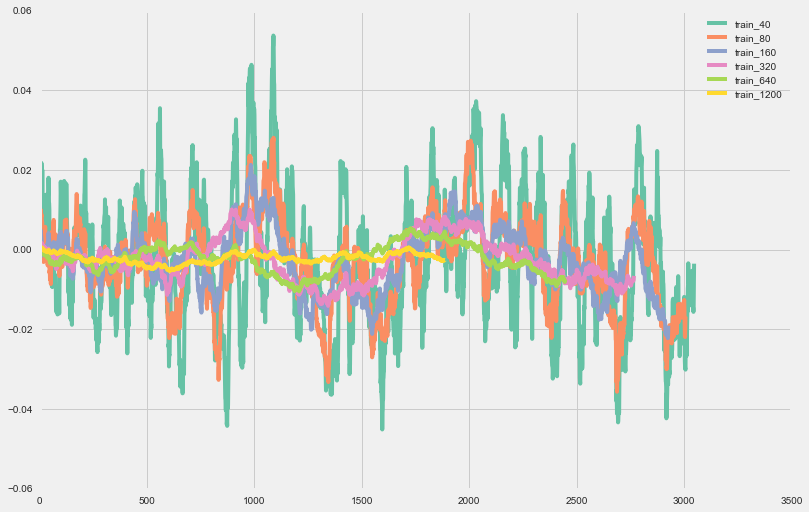

In [122]:
# Let's check the running mean to see if it's shuffled and how many samples are needed for a representative sample
X1n=normalise_bands(X1.copy())
def running_mean(X, N=10):
    # take mean of extra dims
    for i in range(len(X.shape)-1):
        X=X.mean(-1)
    
    return np.convolve(X, np.ones((N,))/N, mode='valid')

for n in [40,80,160,320,640,1200]:
#     plt.plot(running_mean(X_test, n),label='test_%s'%n)
    plt.plot(running_mean(X_train, n),label='train_%s'%n)
#     plt.plot(running_mean(X_val, n),label='val_%s'%n)
plt.legend()

### Compare train,val, test

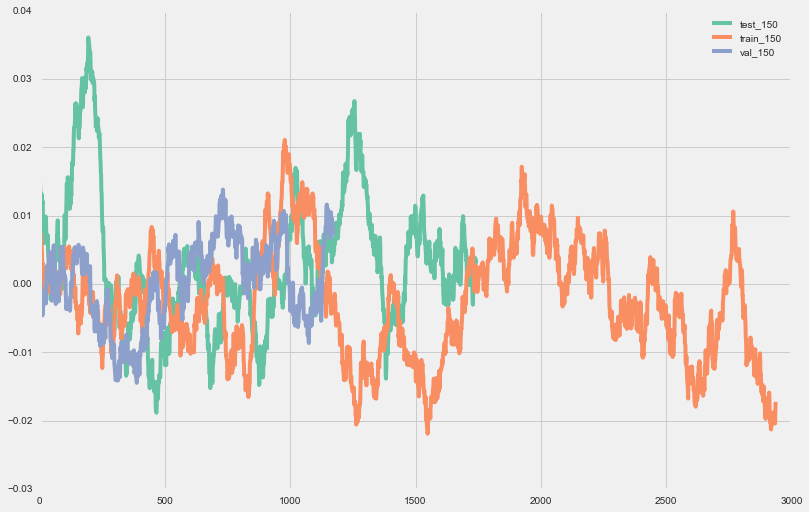

In [123]:
# Let's check the running mean of test,train,val. They should be similar
def running_mean(X, N=10):
    # take mean of extra dims
    for i in range(len(X.shape)-1):
        X=X.mean(-1)
    
    return np.convolve(X, np.ones((N,))/N, mode='valid')

for n in [150]:
    plt.plot(running_mean(X_test, n),label='test_%s'%n)
    plt.plot(running_mean(X_train, n),label='train_%s'%n)
    plt.plot(running_mean(X_val, n),label='val_%s'%n)
plt.legend()

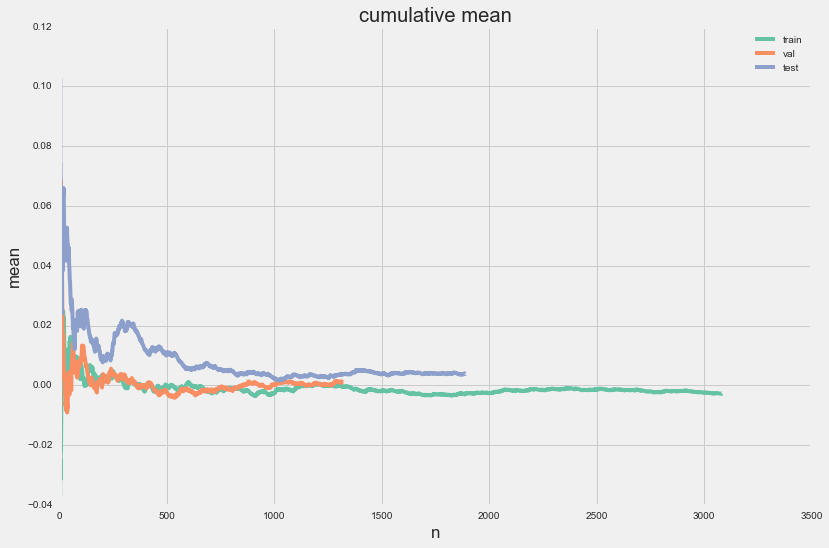

In [124]:
cum_mean1 =  [X_train[:i].mean() for i in range(2,len(X_train))]
cum_mean2 =  [X_val[:i].mean() for i in range(2,len(X_val))]
cum_mean3 =  [X_test[:i].mean() for i in range(2,len(X_test))]
plt.plot(cum_mean1, label='train')
plt.plot(cum_mean2, label='val')
plt.plot(cum_mean3, label='test')
plt.legend()
plt.title('cumulative mean')
plt.xlabel('n')
plt.ylabel('mean')

In [125]:
# cumulative std
cum_mean1 =  [X_train[:i].std() for i in range(2,len(X_train))]
cum_mean2 =  [X_val[:i].std() for i in range(2,len(X_val))]
cum_mean3 =  [X_test[:i].std() for i in range(2,len(X_test))]
plt.plot(cum_mean1, label='train')
plt.plot(cum_mean2, label='val')
plt.plot(cum_mean3, label='test')
plt.legend()
plt.title('cumulative std')
plt.xlabel('n')
plt.ylabel('mean')

KeyboardInterrupt: 

# Visual QC

Check the high res bands 1,2,3 and 7 match the satelite image

In [14]:
metadatas1 = json.load(open(data_path1.joinpath('data_metadata.json')))
script_metadata = json.load(open(data_path1.joinpath('script_metadata.json')))
with h5py.File(data_path1.joinpath('data.h5'),'r') as h5f:
    X1 = h5f['X'][:]
    y1 = h5f['y'][:]
X1.shape, y1, metadatas1[0].keys()#

((1600, 14, 25, 25),
 array([False,  True,  True, ..., False, False,  True], dtype=bool),
 dict_keys(['scale', 'image', 'crs', 'name', 'leak', 'distance']))

In [85]:
# let look at the before and after for one leak
i = np.random.randint(len(X1))
i=32

In [86]:
# find the other image
leak_id = metadatas1[i]['leak']['features'][0]['properties']['leak_id']
mask = [leak_id==m['leak']['features'][0]['properties']['leak_id'] for m in metadatas1]
i_true=np.argwhere(mask)[1][0]
i_false=i
y1[mask], np.argwhere(mask)
t1=arrow.get(metadatas1[i_true]['image']['properties']['system:time_end']/1000)
t0=arrow.get(metadatas1[i_true]['leak']['features'][0]['properties']['REPO_Date'])
print('days:',(t1-t0).total_seconds()/(60*60*24))

days: -1.1212214814930554


In [92]:
t1=arrow.get(metadatas1[i_false]['image']['properties']['system:time_end']/1000)
t0=arrow.get(metadatas1[i_false]['leak']['features'][0]['properties']['REPO_Date'])
print('days:',(t1-t0).total_seconds()/(60*60*24))

days: 108.88388792824074


In [91]:
metadatas1[i_true]['leak']['features'][0]['geometry']

{'coordinates': [-97.71273358324895, 30.343526053474076], 'type': 'Point'}

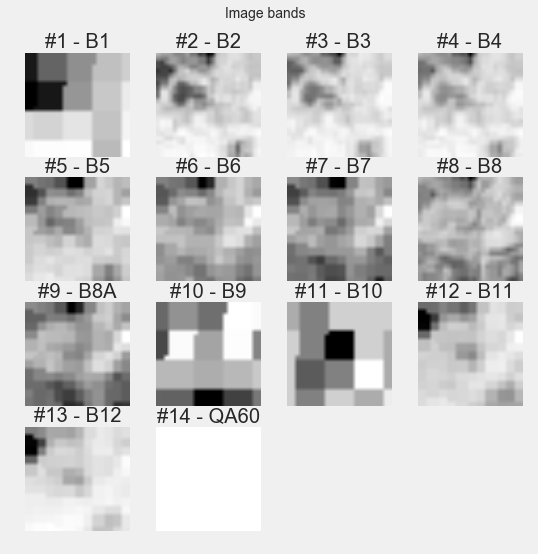

In [88]:
# plt.figure(figsize=((12,12)))
plt.rcParams['figure.figsize'] = (8, 8) # bigger plots
imshow_bands(X1[i_true], labels=bands_s2)

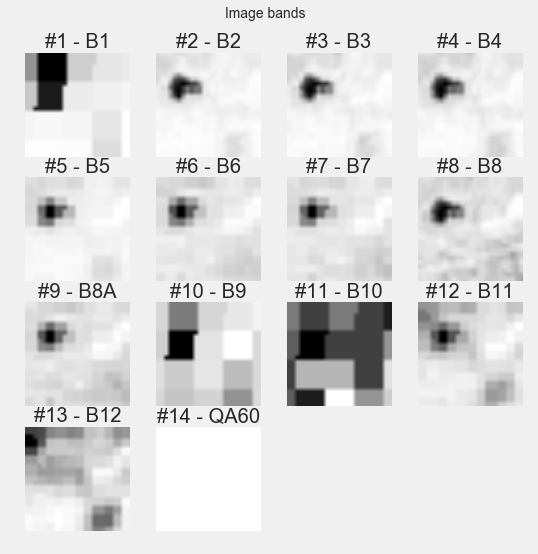

In [89]:
# plt.figure(figsize=((10,[010)))
plt.rcParams['figure.figsize'] = (8, 8) # bigger plots
imshow_bands(X1[i_false], labels=bands_s2)

Visual QC to check that the image above matches the one below

In [138]:
import folium
# from https://jsfiddle.net/marracci/z6hpu087/
dg_recent='http://api.tiles.mapbox.com/v4/digitalglobe.nal0g75k/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiZGlnaXRhbGdsb2JlIiwiYSI6ImNpcGg5dHkzYTAxM290bG1kemJraHU5bmoifQ.CHhq1DFgZPSQQC-DYWpzaQ'
location = metadatas1[i]['leak']['features'][0]['geometry']['coordinates'][::-1]

radius = (50.0*100)/60 # 50m*(100cm/1m)/60cm*
# example https://github.com/python-visualization/folium/blob/master/examples/Geopandas.ipynb
map_osm = folium.Map(tiles=dg_recent, location=location, attr= "DigitalGlobe, Inc", zoom_start=18)
# folium.CircleMarker(location, radius=radius).add_to(map_osm)
folium.CircleMarker(location, radius=radius*2).add_to(map_osm)
folium.Marker(location).add_to(map_osm)
map_osm


Now lets compare band 8 for a selection of images to make sure they are different

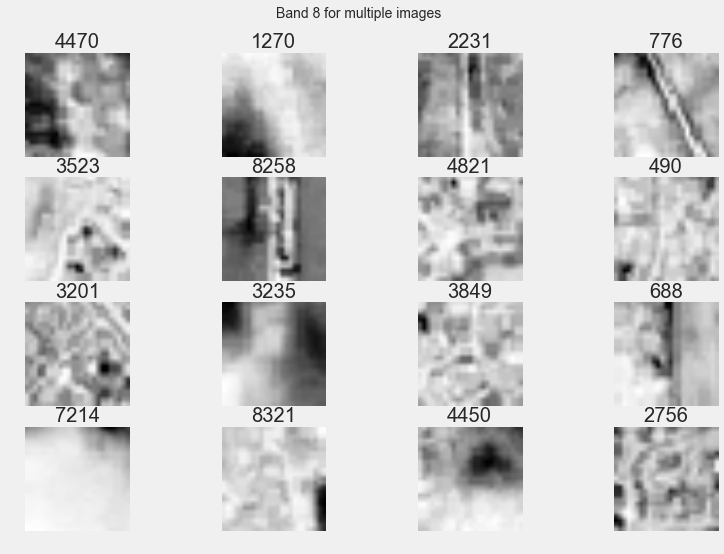

In [130]:
# view some random images to make sure they don't look to similar. 
# just in case we ended up scraping the same place repeatedely

band=7
f, axarr = plt.subplots(4, 4)
for j in range(4*4):
    plt.subplot(4, 4, j + 1)
    i=np.random.randint(len(X1))
    plt.imshow(X1[i][band,:,:])
    plt.grid(False)
    plt.gca().set_axis_off()
    plt.title(str(i))
#     plt.show()

plt.suptitle('Band %s for multiple images'%(band+1) )

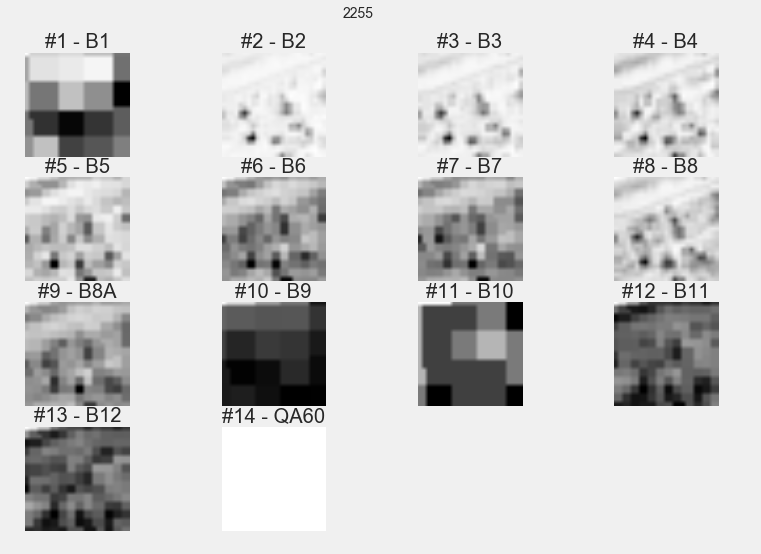

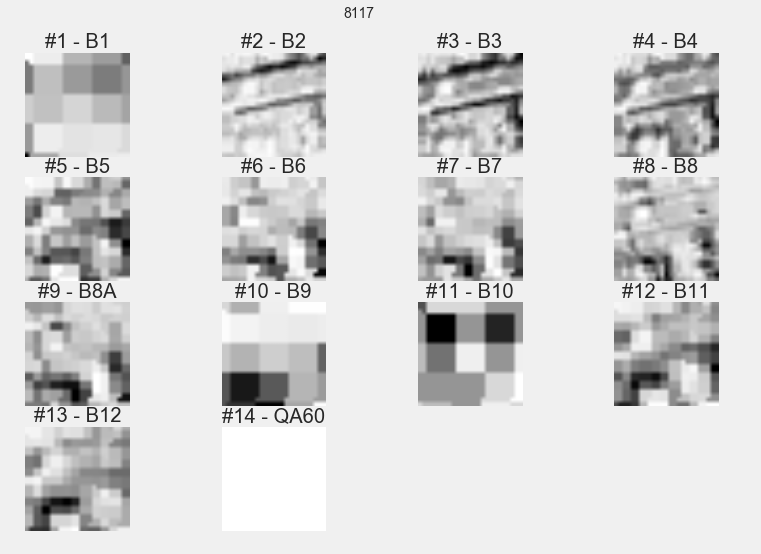

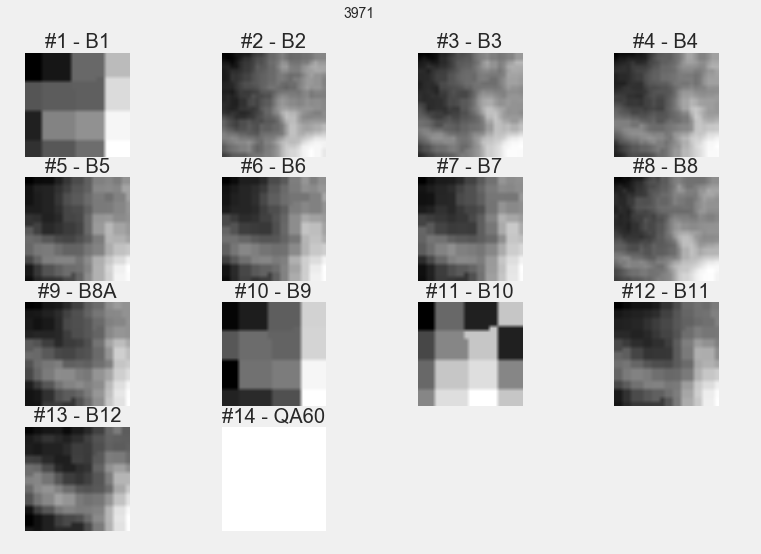

In [131]:
# view some random ones
for j in range(3):
    i=np.random.randint(len(X1))
    imshow_bands(X1[i], labels=bands_s2)
    plt.suptitle(str(i))
    plt.show()


# metadata qc

In [132]:
# overview of properties to make sure I'm not missing some quality flag
import pandas as pd
df_m = pd.DataFrame([mm['image']['properties'] for mm in metadatas1])
df_m

,CLOUDY_PIXEL_PERCENTAGE,CLOUD_COVERAGE_ASSESSMENT,DATASTRIP_ID,DATATAKE_IDENTIFIER,DATATAKE_TYPE,DEGRADED_MSI_DATA_PERCENTAGE,ECMWF_DATA_REF,FORMAT_CORRECTNESS_FLAG,GENERAL_QUALITY_FLAG,GENERATION_TIME,...,SOLAR_IRRADIANCE_B7,SOLAR_IRRADIANCE_B8,SOLAR_IRRADIANCE_B8A,SOLAR_IRRADIANCE_B9,SPACECRAFT_NAME,system:asset_size,system:footprint,system:index,system:time_end,system:time_start
0,0.08,0.03,NaN,GS2A_20160206T015552_003260_N02.01,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_FAKE_19800101T000000_V1980...,PASSED,PASSED,1454768531000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,1230802132,"{'coordinates': [[[119.3343984815876, -31.2345...",20160206T020436_20160206T104528_T50JQL,1454724276194,1454724276194
1,0.01,0.01,S2A_OPER_MSI_L1C_DS_SGS__20161108T071227_S2016...,GS2A_20161108T022612_007207_N02.04,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_PDMC_20161107T120000_V2016...,PASSED,PASSED,1478717845000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,903462844,"{'coordinates': [[[116.82729578233406, -31.589...",20161108T022612_20161108T071227_T50JML,1478571973672,1478571973672
2,0.04,18.26,NaN,GS2A_20160212T022622_003346_N02.01,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_FAKE_19800101T000000_V1980...,PASSED,PASSED,1455269859000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,791112124,"{'coordinates': [[[115.7788827422385, -32.0592...",20160212T022622_20160212T073904_T50HLK,1455243982456,1455243982456
3,7.31,7.31,S2A_OPER_MSI_L1C_DS_SGS__20161009T085955_S2016...,GS2A_20161009T021342_006778_N02.04,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_PDMC_20161008T120000_V2016...,PASSED,PASSED,1476010121000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,1164292140,"{'coordinates': [[[118.57778377822841, -20.312...",20161009T021342_20161009T085955_T50KPC,1475979501868,1475979501868
4,61.54,59.01,S2A_OPER_MSI_L1C_DS_SGS__20160611T085907_S2016...,GS2A_20160611T021352_005062_N02.02,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_PDMC_20160610T120000_V2016...,PASSED,PASSED,1465642664000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,1247716741,"{'coordinates': [[[116.63769279977048, -31.713...",20160611T021829_20160611T085907_T50HMK,1465611509866,1465611509866
5,30.00,12.88,NaN,GS2A_20160113T022622_002917_N02.01,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_FAKE_19800101T000000_V1980...,PASSED,PASSED,1452683768000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,928777344,"{'coordinates': [[[116.04359638683458, -31.904...",20160113T022642_20160113T054624_T50HLK,1452652002497,1452652002497
6,2.69,19.10,S2A_OPER_MSI_L1C_DS_SGS__20160701T090129_S2016...,GS2A_20160701T021352_005348_N02.04,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_PDMC_20160630T120000_V2016...,PASSED,PASSED,1467404483000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,993204997,"{'coordinates': [[[116.5017945239097, -33.2232...",20160701T021831_20160701T090129_T50HMJ,1467339511478,1467339511478
7,95.69,90.23,S2A_OPER_MSI_L1C_DS_SGS__20160708T084756_S2016...,GS2A_20160708T020452_005448_N02.04,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_PDMC_20160707T120000_V2016...,PASSED,PASSED,1467975819000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,1333295396,"{'coordinates': [[[117.71197387001857, -31.598...",20160708T021016_20160708T084756_T50JNL,1467943816763,1467943816763
8,99.00,62.54,NaN,GS2A_20160120T020412_003017_N02.01,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_FAKE_19800101T000000_V1980...,PASSED,PASSED,1453295612000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,1262293368,"{'coordinates': [[[117.66162618291085, -34.629...",20160120T021747_20160120T085856_T50HNG,1453256267814,1453256267814
9,71.65,54.92,S2A_OPER_MSI_L1C_DS_SGS__20160909T071030_S2016...,GS2A_20160909T022612_006349_N02.04,INS-NOBS,0.00,S2__OPER_AUX_ECMWFD_PDMC_20160908T120000_V2016...,PASSED,PASSED,1473415613000,...,"1,163.19","1,036.39",955.19,813.04,Sentinel-2A,1018401190,"{'coordinates': [[[115.79718608376476, -31.742...",20160909T022612_20160909T071030_T50HLK,1473387966460,1473387966460


In [133]:
# %precision 6 
# np.set_printoptions(suppress=True, threshold=6, precision=6) # only do float if it's 1E7 or 1E-7
pd.options.display.float_format = '{:20,.2f}'.format
df_m.describe().T

,count,mean,std,min,25%,50%,75%,max
CLOUDY_PIXEL_PERCENTAGE,"9,030.00",29.22,31.29,0.00,0.17,19.82,50.70,100.00
CLOUD_COVERAGE_ASSESSMENT,"9,030.00",29.32,27.42,0.00,7.83,19.10,47.43,100.00
DEGRADED_MSI_DATA_PERCENTAGE,"9,030.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
GENERATION_TIME,"9,030.00","1,463,376,569,628.68","38,468,391,214.19",0.00,"1,459,488,142,000.00","1,464,517,643,000.00","1,469,102,311,000.00","1,481,767,729,000.00"
MEAN_INCIDENCE_AZIMUTH_ANGLE_B1,"9,030.00",185.60,73.99,96.68,103.73,177.27,277.02,294.29
MEAN_INCIDENCE_AZIMUTH_ANGLE_B10,"9,030.00",186.14,73.97,96.83,102.67,178.22,278.43,290.30
MEAN_INCIDENCE_AZIMUTH_ANGLE_B11,"8,358.00",183.42,73.87,96.64,103.01,177.17,274.84,292.03
MEAN_INCIDENCE_AZIMUTH_ANGLE_B12,"8,358.00",183.21,73.85,96.62,103.42,176.91,274.27,293.72
MEAN_INCIDENCE_AZIMUTH_ANGLE_B2,"9,030.00",187.84,73.99,97.49,102.04,181.99,280.39,287.99
MEAN_INCIDENCE_AZIMUTH_ANGLE_B3,"9,030.00",186.73,74.04,97.07,102.37,179.89,279.13,289.43


In [134]:
# does the irradience change, we can see above that the std is tiny, so no


In [139]:
# how many are too cloudy
(df_m.CLOUD_COVER>30).sum()/len(df_m)

AttributeError: 'DataFrame' object has no attribute 'CLOUD_COVER'

In [140]:
df_m.CLOUD_COVER.plot.kde()
df_m.CLOUD_COVER.plot.hist(bins=20, normed=True)

AttributeError: 'DataFrame' object has no attribute 'CLOUD_COVER'

# Visualise each band

In [150]:



# which bands do we have and how often?
bands_filled = list(np.argwhere(x).flatten() for x in X1.sum(-1).sum(-1)!=0)
bands_filled=np.array(bands_filled)
collections.Counter(np.concatenate(bands_filled))


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/pandas/types/dtypes.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


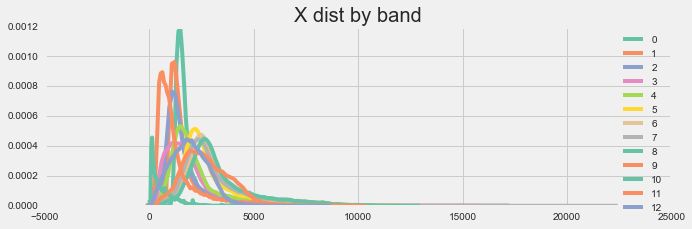

In [152]:
X_df = pd.DataFrame(X1.reshape(-1,(X1.shape[0]*25*25)).T,columns=script_metadata['bands'])
plt.figure(figsize=(10,3))
for band in range(X1.shape[1]-1):
    s = pd.Series(X1[:,band,:,:].flat)
    sns.kdeplot(s, 
                 label=str(band),
                shade=False
                )
plt.legend()
# plt.ylim(0,0.005)
plt.title('X dist by band')

/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/pandas/types/dtypes.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


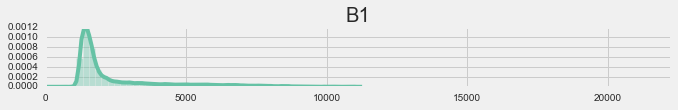

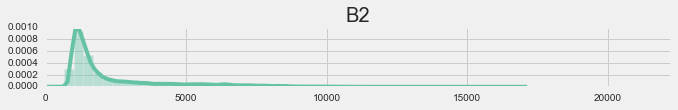

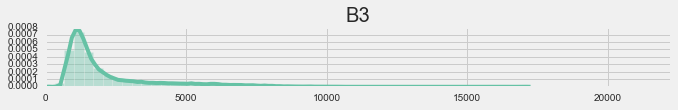

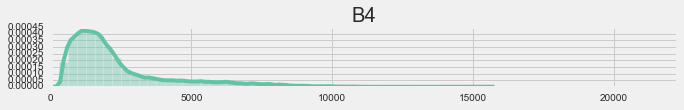

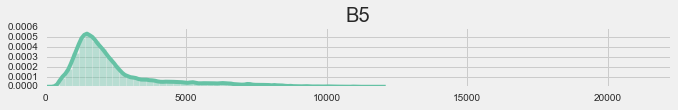

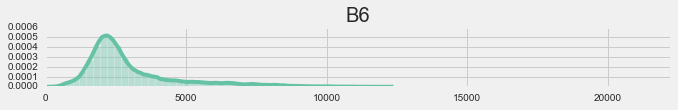

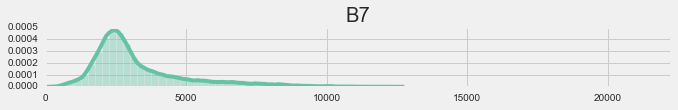

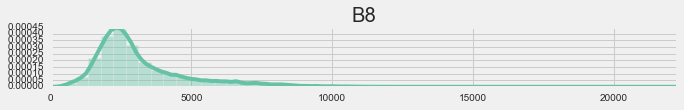

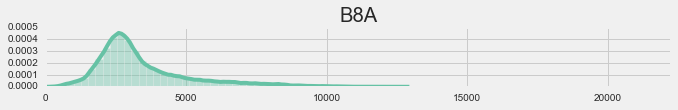

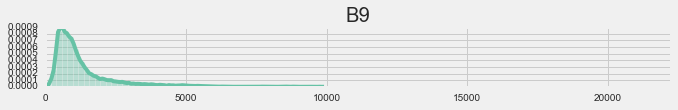

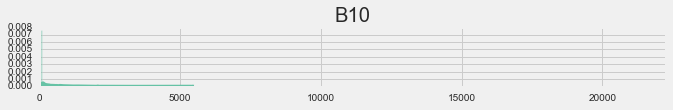

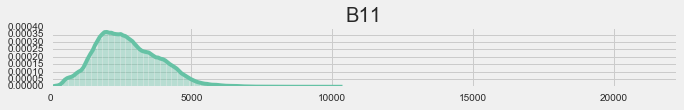

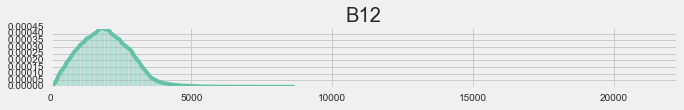

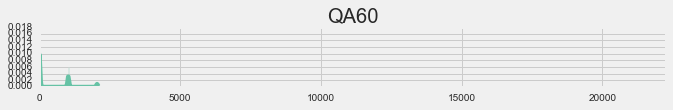

In [149]:
# each band by itself
for band in range(X1.shape[1]):
    plt.figure(figsize=(10,1))
    plt.title(script_metadata['bands'][band])
    s = pd.Series(X1[:,band,:,:].flat)
    sns.distplot(s,label=str(band))
    plt.xlim(X1.min(),X1.max())
    plt.show()